# Uncertainty Evaluation (resnet34 from scratch on Office-31)

In [92]:
# for Google Colab
%pip install torchinfo wandb

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import torch
import torchvision
import wandb
from tqdm.autonotebook import trange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
!wandb login

wandb: Currently logged in as: wei2912. Use `wandb login --relogin` to force relogin


In [94]:
run = wandb.init(
    project="i2r-active-da-02_uncertainty_office-31",
    job_type="train",
    config={
        # parameters roughly similar to LIRR
        "optim": {
            "algorithm": "AdamW",
            # "scheduler": "CosA",
            "lr": 1e-3,
            "weight_decay": 5e-4,
        },
        "params": {
            "batch_size": 64,
            "num_epochs": 30,
            "T": 0.5,
        },
        "cuda_device": 0,
        "architecture": "resnet34-cosc",
        "train_dataset": "office-31_amazon",
        "test_dataset": "office-31_dslr",
        "seed": 123456,
    },
)
config = run.config

run.tags += (config.architecture,)
if config.train_dataset == config.test_dataset:
    run.tags += (config.train_dataset,)
else:
    run.tags += (f"{config.train_dataset}-to-{config.test_dataset}",)

## Office-31 Dataset

On first project run, please download the dataset at https://github.com/jindongwang/transferlearning/blob/master/data/dataset.md#office-31 and extract to `data/office-31`.

In [95]:
try:
    artifact = run.use_artifact("office-31-dataset:latest")
    artifact.download("data/office-31/")
except wandb.CommError as e:
    print("Uploading data to WandB.")
    artifact = wandb.Artifact("office-31-dataset", type="dataset")
    artifact.add_dir("data/office-31/")
    run.log_artifact(artifact)

wandb: Downloading large artifact office-31-dataset:latest, 78.76MB. 4110 files... 
wandb:   4110 of 4110 files downloaded.  
Done. 0:0:0.9


In [96]:
from torch.utils.data import Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

# from utils import get_balanced_ids

match config.train_dataset:
    case "office-31_amazon":
        train_data = ImageFolder(
            root="data/office-31/amazon/images",
            transform=Compose([Resize(224), ToTensor()]),
        )

train_loader = torch.utils.data.DataLoader(
    train_data,
    # Subset(train_data, list(get_balanced_ids(train_data, seed=config.seed))),
    batch_size=config.params["batch_size"],
    shuffle=True,
    pin_memory=True,
)

match config.test_dataset:
    case "office-31_dslr":
        test_data = ImageFolder(
            root="data/office-31/dslr/images",
            transform=Compose([Resize(224), ToTensor()]),
        )
    case "office-31_webcam":
        test_data = ImageFolder(
            root="data/office-31/webcam/images",
            transform=Compose([Resize(224), ToTensor()]),
        )

test_loader = torch.utils.data.DataLoader(
    test_data,
    # Subset(test_data, list(get_balanced_ids(test_data, seed=config.seed+1))),
    batch_size=config.params["batch_size"],
    pin_memory=True,
)

assert sorted(train_data.class_to_idx.items()) == sorted(test_data.class_to_idx.items())

torch.Size([64, 3, 224, 224])
Label: 5


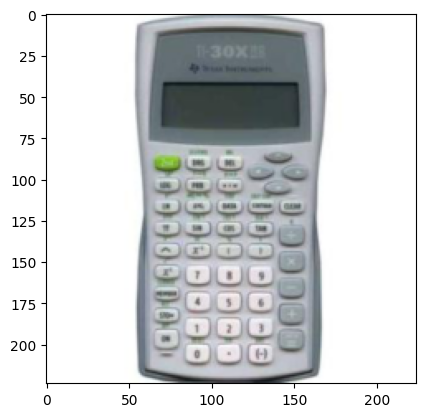

In [97]:
train_inputs, train_targets = next(iter(train_loader))
plt.imshow(torch.einsum("cwh->whc", train_inputs[0]))

print(train_inputs.size())
print(f"Label: {train_targets[0]}")

torch.Size([64, 3, 224, 224])
Label: 0


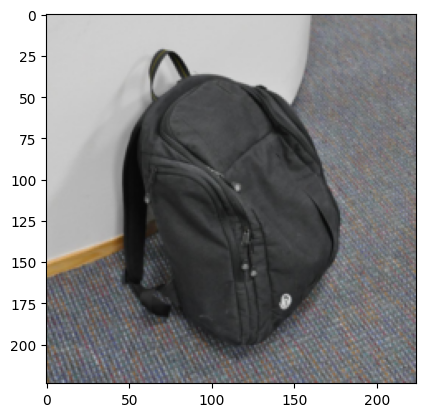

In [98]:
test_inputs, test_targets = next(iter(test_loader))
plt.imshow(torch.einsum("cwh->whc", test_inputs[0]))
assert train_inputs.size() == test_inputs.size()

print(test_inputs.size())
print(f"Label: {test_targets[0]}")

In [99]:
from itertools import chain, cycle

train_targets = (
    train_data.classes[target]
    for _, targets in train_loader
    for target in targets.tolist()
)
test_targets = (
    test_data.classes[target]
    for _, targets in test_loader
    for target in targets.tolist()
)

df = pd.DataFrame(
    data=chain(zip(train_targets, cycle([False])), zip(test_targets, cycle([True]))),
    columns=["target", "is_test"],
)
fig = px.histogram(
    df,
    x="target",
    color="is_test",
    barmode="overlay",
    category_orders=dict(target=train_data.classes),
)
fig.show()

## Training Setup

In [100]:
torch.cuda.set_device(config.cuda_device)
device = torch.device(
    f"cuda:{config.cuda_device}" if torch.cuda.is_available() else "cpu"
)

In [101]:
from torch.nn import CosineSimilarity, Linear, Module, Sequential
from torchinfo import summary
from torchvision.models import resnet18, resnet34


class InvScale(Module):
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale

    def forward(self, x):
        return x / self.scale


class CosC(Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.fc = Linear(**kwargs, bias=False)
        self.cos = CosineSimilarity(dim=1)

    def forward(self, x):
        x = x.reshape(x.size() + (1,))
        w_t = self.fc.weight.T.reshape((1,) + self.fc.weight.T.size())
        return self.cos(x, w_t)


T = config.params["T"] if "T" in config.params else 1

match config.architecture:
    case "resnet18":
        model = resnet18(weights=None).to(device)
        model.fc = Sequential(
            Linear(
                in_features=model.fc.in_features,
                out_features=len(train_data.classes),
                bias=True,
            ),
            InvScale(scale=T),
        )
    case "resnet18-cosc":
        model = resnet18(weights=None).to(device)
        model.fc = Sequential(
            CosC(
                in_features=model.fc.in_features, out_features=len(train_data.classes)
            ),
            InvScale(scale=T),
        )
    case "resnet34":
        model = resnet34(weights=None).to(device)
        model.fc = Sequential(
            Linear(
                in_features=model.fc.in_features,
                out_features=len(train_data.classes),
                bias=True,
            ),
            InvScale(scale=T),
        )
    case "resnet34-cosc":
        model = resnet34(weights=None).to(device)
        model.fc = Sequential(
            CosC(
                in_features=model.fc.in_features, out_features=len(train_data.classes)
            ),
            InvScale(scale=T),
        )

summary(model, input_size=(config.params["batch_size"], 3, 224, 224), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 31]                  --
├─Conv2d: 1-1                            [64, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [64, 64, 112, 112]        128
├─ReLU: 1-3                              [64, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [64, 64, 56, 56]          --
├─Sequential: 1-5                        [64, 64, 56, 56]          221,952
├─Sequential: 1-6                        [64, 128, 28, 28]         1,116,416
├─Sequential: 1-7                        [64, 256, 14, 14]         6,822,400
├─Sequential: 1-8                        [64, 512, 7, 7]           13,114,368
├─AdaptiveAvgPool2d: 1-9                 [64, 512, 1, 1]           --
├─Sequential: 1-10                       [64, 31]                  15,872
Total params: 21,300,544
Trainable params: 21,300,544
Non-trainable params: 0
Total mult-adds (G): 234.45
Input size (MB

In [102]:
def save_model(epoch):
    if config.train_dataset == config.test_dataset:
        model_name = f"{config.architecture}-{config.train_dataset}"
    else:
        model_name = (
            f"{config.architecture}-{config.train_dataset}-to-{config.test_dataset}"
        )
    torch.save(model, f"{run.dir}/{model_name}-{epoch:03}.pt")
    wandb.save(f"{run.dir}/{model_name}-{epoch:03}.pt", base_path=run.dir)

In [103]:
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = CrossEntropyLoss().to(device)

match config.optim.get("algorithm"):
    case "AdamW":
        optimizer = AdamW(
            model.parameters(),
            lr=config.optim["lr"],
            weight_decay=config.optim["weight_decay"],
        )
    case "SGD":
        optimizer = SGD(
            model.parameters(),
            lr=config.optim["lr"],
            weight_decay=config.optim["weight_decay"],
        )

match config.optim.get("scheduler"):
    case None:
        scheduler = None
    case "CosA":
        scheduler = CosineAnnealingLR(optimizer, config.params["num_epochs"])

In [104]:
from sklearn.metrics import top_k_accuracy_score
import time


def train_epoch():
    model.train()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for input, target in train_loader:
        if device is not None:
            input = input.to(device)
            target = target.to(device)

        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.tolist())
        targets.extend(target.tolist())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if scheduler is None:
        lr = config.optim["lr"]
    else:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

    end = time.monotonic()

    return {
        "lr": lr,
        "time": end - start,
        "loss": sum(losses) / len(losses),
        "top1": top_k_accuracy_score(
            targets, outputs, k=1, labels=range(len(train_data.classes))
        ),
    }

In [105]:
def test_epoch():
    model.eval()

    start = time.monotonic()

    losses = []
    outputs = []
    targets = []
    for input, target in test_loader:
        if device is not None:
            input = input.to(device)
            target = target.to(device)

        output = model(input)
        loss = criterion(output, target)

        losses.append(loss.item())
        outputs.extend(output.tolist())
        targets.extend(target.tolist())

    end = time.monotonic()

    return (
        outputs,
        targets,
        {
            "time": end - start,
            "loss": sum(losses) / len(losses),
            "top1": top_k_accuracy_score(
                targets, outputs, k=1, labels=range(len(test_data.classes))
            ),
        },
    )

### Uncertainty Metrics

In [106]:
def softmax(outputs):
    return np.exp(outputs) / np.sum(np.exp(outputs), axis=1).reshape(
        (outputs.shape[0], 1)
    )


def predictive_entropy(pss):
    return (-pss * np.log(pss)).sum(axis=1)


def margin(pss):
    inds = np.argsort(pss, axis=1)
    max2s = np.take_along_axis(pss, inds[:, -2:], axis=1)
    return max2s[:, 1] - max2s[:, 0]

In [107]:
pss = softmax(np.array([[1, 2, 3, 4], [2, 4, 3, 6]]))
print(pss)
print(predictive_entropy(pss))
print(margin(pss))

[[0.0320586  0.08714432 0.23688282 0.64391426]
 [0.01521943 0.11245721 0.0413707  0.83095266]]
[0.94753696 0.59508669]
[0.40703144 0.71849545]


In [108]:
from itertools import cycle

save_model(0)

df_epochs = []
for epoch in trange(1, config.params["num_epochs"] + 1):
    train_metrics = train_epoch()
    save_model(epoch)
    outputs, targets, test_metrics = test_epoch()

    targets, outputs = np.array(targets), np.array(outputs)
    pss = softmax(outputs)
    cs = np.argmax(pss, axis=1) == targets
    pes = predictive_entropy(pss)
    ms = margin(pss)

    df_epoch = pd.DataFrame(
        data=zip(cycle([epoch]), targets, outputs, pss, cs, pes, ms),
        columns=[
            "epoch",
            "target",
            "output",
            "probs",
            "is_correct",
            "predictive_entropy",
            "margin",
        ],
    )
    df_epochs.append(df_epoch)

    run.log(
        {
            "epoch": epoch,
            "train": train_metrics,
            "test": test_metrics,
            "uncertainty_metrics": wandb.Table(data=df_epoch),
        }
    )

  0%|          | 0/30 [00:00<?, ?it/s]

In [109]:
df = pd.concat(df_epochs)
df.to_pickle(f"{run.dir}/df_uncertainty_metrics.pickle")
wandb.save(f"{run.dir}/df_uncertainty_metrics.pickle", base_path=run.dir)
df

,epoch,target,output,probs,is_correct,predictive_entropy,margin
0,1,0,"[-0.02441757544875145, -0.774919331073761, -0....","[0.03180609436860687, 0.015016598599642429, 0....",False,3.364250,0.002334
1,1,0,"[0.43673139810562134, -0.6798804402351379, -0....","[0.050022774332325125, 0.01637681393481315, 0....",False,3.357372,0.005378
2,1,0,"[-0.06834657490253448, -0.7861630320549011, -0...","[0.030865215360506983, 0.015056553970494414, 0...",False,3.369569,0.006227
3,1,0,"[0.21686501801013947, -0.7185293436050415, -0....","[0.04108422617152435, 0.01612272705268212, 0.0...",False,3.367424,0.010915
4,1,0,"[0.35235464572906494, -0.6950085163116455, -0....","[0.04634908438518935, 0.0162621183491772, 0.01...",False,3.361107,0.005003
...,...,...,...,...,...,...,...
493,30,30,"[-0.29957035183906555, -0.26560333371162415, -...","[0.018824149551205524, 0.019474533043265917, 0...",False,3.159961,0.021437
494,30,30,"[-0.3404906988143921, -0.30727213621139526, -0...","[0.017935990001508105, 0.0185418042400492, 0.0...",False,3.168057,0.034000
495,30,30,"[-0.34942349791526794, -0.296064555644989, -0....","[0.01736997850432847, 0.01832199562859922, 0.0...",False,3.203534,0.006663
496,30,30,"[-0.23667368292808533, -0.19634310901165009, -...","[0.018076783051491466, 0.018820731177303023, 0...",False,3.041546,0.004948


## Analysis

In [110]:
fig = px.histogram(
    df,
    x="predictive_entropy",
    color="is_correct",
    animation_frame="epoch",
    barmode="overlay",
    histnorm="probability",
    range_x=(3.0, 3.4),
    range_y=(0, 1),
)
fig.update_traces(xbins_size=0.02)
fig.update_layout(width=600, height=600)
fig.write_html(f"{run.dir}/hist_predictive_entropy.html", auto_play=False)
fig.show()

In [113]:
fig = px.histogram(
    df,
    x="margin",
    color="is_correct",
    barmode="overlay",
    animation_frame="epoch",
    histnorm="probability",
    range_x=(0, 0.2),
    range_y=(0, 1),
)
fig.update_traces(xbins_size=0.01)
fig.update_layout(width=600, height=600)
fig.write_html(f"{run.dir}/hist_margin.html", auto_play=False)
fig.show()

In [114]:
table = wandb.Table(columns=["predictive_entropy", "margin"])
table.add_data(
    wandb.Html(f"{run.dir}/hist_predictive_entropy.html"),
    wandb.Html(f"{run.dir}/hist_margin.html"),
)
run.log({"uncertainty_figs": table})

if input("Finish the WandB run? [Y/n] ").strip().lower() == "y":
    run.finish()

Finish the WandB run? [Y/n] y


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch,30
